## This notebook is used to visualize the concatenated utterances, features and the ground truth labels

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import soundfile as sf
import pickle
from copy import copy
import torch
from vad import Net

FILE = 'a0/909-131045-0028_2136-5143-0003_1594-135914-0014'
with open('../data/features/train/' + FILE + '.fea', 'rb') as f:
    x, y = pickle.load(f)

audio, sr = sf.read('../data/concat/' + FILE + '.flac')

model = Net(40, 64, 2)
model.load_state_dict(torch.load('models/model.pt'))

new_y = np.kron(y, np.ones(160))
new_x = np.kron(x[:,0] + x[:,1], np.ones(160))

In [16]:
# Let's find the shortest sequence of zeroes in the array
min_len = 200000
index = 100000000000
inside = False
for i in range(y.size):
    if y[i] == 0:
        if not inside:
            inside = True
            curr = 1
        else:
            curr += 1
    else:
        if inside:
            inside = False
            if curr < min_len:
                min_len = copy(curr)
                index = copy(i)
seq = np.zeros(y.size*160)
seq[(index-min_len)*160:index*160] = 1

print("Minimal sequence length is:", min_len)

Minimal sequence length is: 8


In [17]:
# Define a function to replace zero sequences of lenght 'seq_len'
def replace_zero_sequences(arr, seq_len):
    inside = False
    for i in range(arr.size):
        if arr[i] == 0:
            if not inside:
                inside = True
                curr = 1
            else:
                curr += 1
        else:
            if inside:
                if curr < seq_len: # replace the short sequence
                    arr[i - curr:i] = 1.
                inside = False
    return arr

In [65]:
# get the model to generate a label vector for us

conv_filter = np.array([1/8]*8)
conv_filter2 = np.cos([1, 0, -1, 0])

with torch.no_grad():
    x_torch = torch.nn.utils.rnn.pack_padded_sequence(torch.unsqueeze(torch.from_numpy(x).float(), 0),
                                                      torch.tensor([y.size]), batch_first=True)
    output_raw = torch.squeeze(model(x_torch)).numpy()
    output_hard = output_raw > 0.5
    #output_conv = np.convolve(output_raw, conv_filter)
    output_conv = np.convolve(np.convolve(output_raw, conv_filter), conv_filter2)
    output_conv_hard = output_conv > 0.5
    o_raw = np.kron(output_raw, np.ones(160))
    o_hard = np.kron(output_hard, np.ones(160))
    o_smooth = np.kron(replace_zero_sequences(output_hard, 8), np.ones(160))
    o_conv = np.kron(output_conv, np.ones(160))

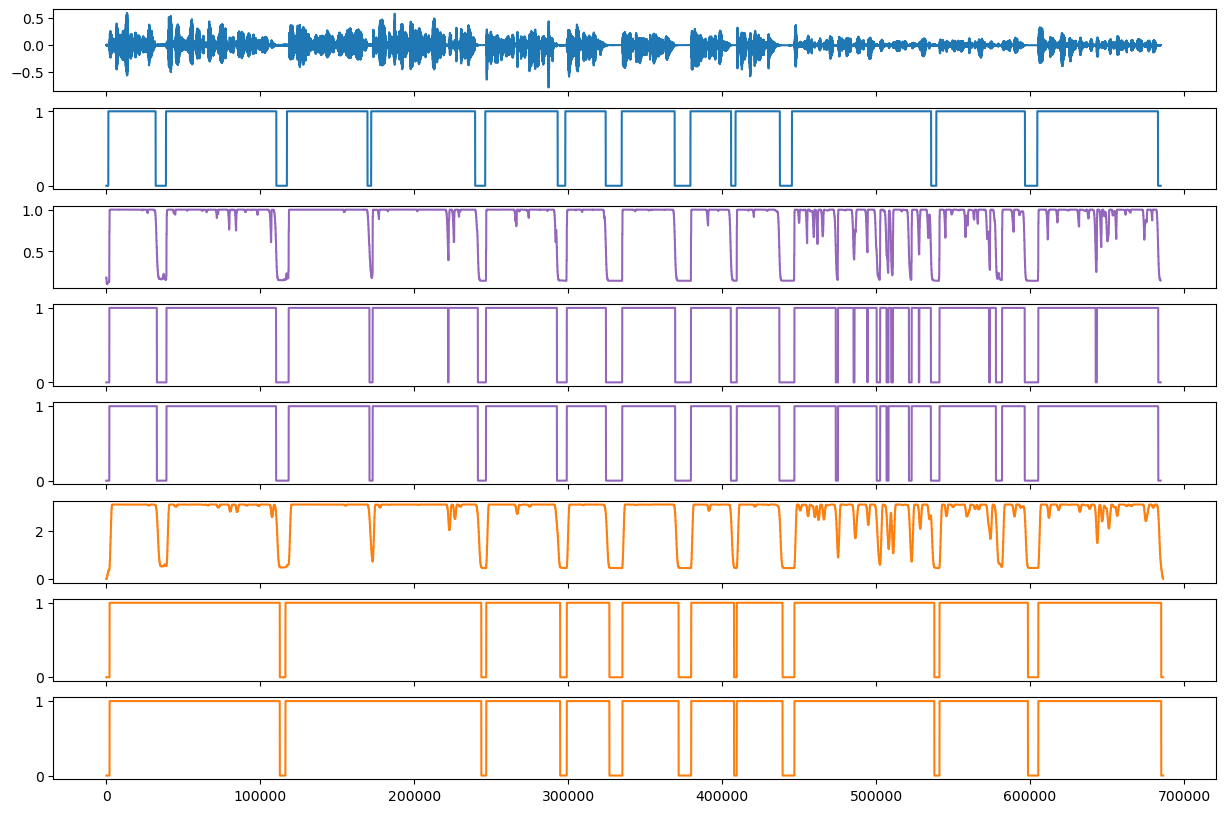

In [66]:
# Plot the original signal and labels plus the first two filterbank coefficients,
# the original shortest sequence and the edited label vector
mpl.style.use('default')
_, ax = plt.subplots(8, 1, figsize=(15,10), sharex=True)
ax[0].plot(audio)
ax[1].plot(new_y)
#ax[2].plot(new_x)
#ax[3].plot(seq)  # plot the position of the shortest sequence
#ax[2].plot(np.kron(replace_zero_sequences(y, 13), np.ones(160))) # deleted super short sequences
ax[2].plot(o_raw, 'C4') # plot the vad prediction
ax[3].plot(o_hard, 'C4') # plot the vad hard thresholded decision
ax[4].plot(o_smooth, 'C4') # plot the vad hard thresholded decision with short sequences removed
ax[5].plot(o_conv, 'C1') # plot the vad filtered decision
ax[6].plot(np.kron(output_conv_hard, np.ones(160)), 'C1') # filtered, thresholded
ax[7].plot(np.kron(replace_zero_sequences(output_conv_hard, 10), np.ones(160)), 'C1') # filtered, thresholded, replaced short sequences

# 909-131045-0028_2136-5143-0003_1594-135914-0014 - real bad performance for lower volume